In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
from tqdm import tqdm
import random
from random import shuffle

In [2]:
import cv2
import numpy as np
import random
import os
import re
from tqdm import tqdm
from copy import deepcopy
import sys

import cv2
import numpy as np
from tqdm import tqdm
from multiprocessing import Process, Manager


In [3]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data, figsize=(16,8), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.imshow(convert_to_rgb(data.astype(int)))
    plt.title(title)
    plt.show()

## 读取数据

In [4]:
def convert_to_rgb(img):
    img = deepcopy(img)
    b,g,r = cv2.split(img)  
    img = cv2.merge([r,g,b])
    return img

In [5]:
background = cv2.imread('../../base_data/background.jpeg')
hedge = cv2.imread('../../base_data/hedge.jpeg')

## 生成视频代码

In [6]:
def generate_video(frame_dir=None, video_dir=None, video_name='video.avi'):

    image_num = len([i for i in os.listdir(frame_dir) if '.jpg' in i])
    image_name_list = [f'{i}.jpg' for i in range(image_num)]
    frame = cv2.imread(os.path.join(frame_dir, image_name_list[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(f'{video_dir}/{video_name}', 0, 20, (width, height))

    # video = cv2.VideoWriter(f'{self.video_dir}/{video_name}', 0, 20, (width, height))

    for image in image_name_list:
        video.write(cv2.imread(os.path.join(frame_dir, image)))

    cv2.destroyAllWindows()
    video.release()

## 显示图片

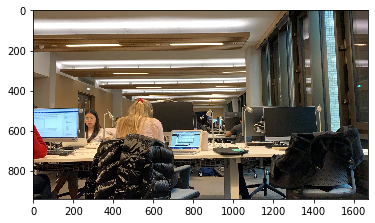

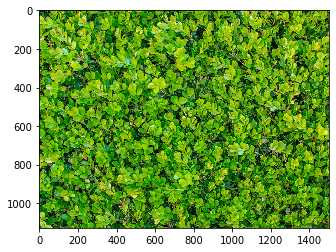

In [7]:
plt.imshow(convert_to_rgb(background))
plt.show()
plt.imshow(convert_to_rgb(hedge))
plt.show()

In [8]:
background.shape, hedge.shape

((941, 1672, 3), (1128, 1504, 3))

## 定义参数

In [9]:
speed_dict = {
    "background": 0,
    "hedge_1": 2,
    "hedge_2": 3,
    "black_bar": 4
}

crop_height = 900
crop_width = 1500
slide_width = 800
camera_width = 250

crop_width_extend = crop_width + 1000

size_1 = camera_width * 2
size_2 = slide_width

dimension = 3
black_bar_width = 5


noise_average_size = 10

vertical_movement = [0]
horizontal_movement = [1, 2]

In [10]:
background_crop = deepcopy(background[-crop_height:, :crop_width, :])
# live_plot(background_crop)

In [11]:
hedge_crop = deepcopy(hedge[-crop_height:, :crop_width, :])
# live_plot(hedge_crop)

## 生成噪声图

In [12]:
def generate_black_bar_image():
    black_bar_image = np.zeros((crop_height, crop_width_extend, dimension))
    for i in range(150, crop_width_extend, 200):
        black_bar_image[:, i - black_bar_width:i + black_bar_width, :] = 1
    return black_bar_image

def generate_random_hole(background_prob=0.7):
    random_hole = np.random.random_sample((crop_height + noise_average_size,
                                           crop_width_extend + noise_average_size))
    random_hole = np.round(random_hole - (background_prob / 2))
    group_random_hole = np.zeros((crop_height, crop_width))
    for i in range(group_random_hole.shape[0]):
        for j in range(group_random_hole.shape[1]):
            group_random_hole[i, j] = random_hole[i:i + noise_average_size, j:j + noise_average_size].mean()
    group_random_hole = np.round(group_random_hole / group_random_hole.max())
    group_random_hole = np.array([[[j] * 3 for j in i] for i in group_random_hole])
    return group_random_hole.astype(int)

In [13]:
black_bar_image = generate_black_bar_image()

In [14]:
# live_plot(random_hole_2 * 255)

In [15]:
# live_plot(((1 - black_bar_image)*255).astype(int))

In [16]:
for bp in range(100,0,-1):
    random_hole_1 = generate_random_hole(bp/100)
    random_hole_2 = generate_random_hole(bp/100)

    verti_pos = int(background_crop.shape[0]/2)
    hori_pos = 0
    for i in tqdm(range(10000), ncols=70):
        try:
            upper, lower = verti_pos + camera_width, verti_pos - camera_width
            background_pos = int(speed_dict['background'] * hori_pos)
            hedge_1_pos = int(speed_dict['hedge_1'] * hori_pos)
            hedge_2_pos = int(speed_dict['hedge_2'] * hori_pos)
            black_bar_pos = int(speed_dict['black_bar'] * hori_pos)

            background_crop_temp = background_crop[int(lower):int(upper), background_pos:background_pos + slide_width, :]
            hedge_1_image_temp = hedge_crop[int(lower):int(upper), hedge_1_pos:hedge_1_pos + slide_width, :]
            random_hole_1_temp = random_hole_1[int(lower):int(upper), hedge_1_pos:hedge_1_pos + slide_width, :]

            hedge_2_image_temp = hedge_crop[int(lower):int(upper), hedge_2_pos:hedge_2_pos + slide_width, :]
            random_hole_2_temp = random_hole_2[int(lower):int(upper), hedge_2_pos:hedge_2_pos + slide_width, :]

            black_bar_image_temp = black_bar_image[int(lower):int(upper), black_bar_pos:black_bar_pos + slide_width, :]

            output_image = background_crop_temp * (1 - random_hole_1_temp) + hedge_1_image_temp * random_hole_1_temp
            output_image = output_image * (1 - random_hole_2_temp) + hedge_2_image_temp * random_hole_2_temp
            output_image = output_image * (1 - black_bar_image_temp) + black_bar_image_temp
            output_image = output_image.astype(int)
            background_true = (1 - random_hole_1_temp) * (1 - random_hole_2_temp) * (1 - black_bar_image_temp)
            background_true_prob = int(np.sum(background_true) * 100/background_true.reshape(-1,1).shape[0])
            directory = f'../scene_data/{bp}'
            if not os.path.exists(directory):
                os.makedirs(directory)
            cv2.imwrite(f"{directory}/{i}_{verti_pos}_{background_pos}_{background_true_prob}.jpg", output_image)

            hori_pos += random.choice(horizontal_movement)
            verti_pos += random.choice(vertical_movement)
        except Exception as e:
            print(e)
            break

/home/yf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
  2%|▍                            | 155/10000 [00:07<08:05, 20.29it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 153/10000 [00:07<08:05, 20.27it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 150/10000 [00:07<07:40, 21.39it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 153/10000 [00:07<07:41, 21.34it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 162/10000 [00:07<07:36, 21.54it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 150/10000 [00:06<07:38, 21.50it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 162/10000 [00:07<07:41, 21.33it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 165/10000 [00:08<08:12, 19.98it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 159/10000 [00:08<08:23, 19.54it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 156/10000 [00:07<07:48, 20.99it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 157/10000 [00:08<08:28, 19.37it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 156/10000 [00:07<07:48, 21.01it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 157/10000 [00:07<07:52, 20.83it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 155/10000 [00:07<07:47, 21.06it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 161/10000 [00:07<07:48, 20.99it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 158/10000 [00:07<07:57, 20.62it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 156/10000 [00:07<07:54, 20.75it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 151/10000 [00:07<07:57, 20.61it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 152/10000 [00:07<07:57, 20.64it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 159/10000 [00:07<08:03, 20.34it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  1%|▍                            | 147/10000 [00:07<08:01, 20.44it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 164/10000 [00:08<07:59, 20.49it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 160/10000 [00:07<07:55, 20.71it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 154/10000 [00:07<07:55, 20.73it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 150/10000 [00:07<08:08, 20.18it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 145/10000 [00:07<08:00, 20.52it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 156/10000 [00:07<08:00, 20.47it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 154/10000 [00:07<08:00, 20.51it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 149/10000 [00:07<08:01, 20.45it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 152/10000 [00:07<08:09, 20.13it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 152/10000 [00:07<08:03, 20.38it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 155/10000 [00:07<08:02, 20.41it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  1%|▍                            | 149/10000 [00:07<08:06, 20.25it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 154/10000 [00:07<08:03, 20.37it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 160/10000 [00:07<08:00, 20.48it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 157/10000 [00:07<07:58, 20.57it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 151/10000 [00:07<08:05, 20.29it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 157/10000 [00:07<08:01, 20.45it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 158/10000 [00:07<08:00, 20.48it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 151/10000 [00:07<08:02, 20.43it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 156/10000 [00:07<07:57, 20.61it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<08:00, 20.51it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<08:02, 20.42it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 153/10000 [00:07<08:04, 20.34it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<08:01, 20.44it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<08:05, 20.28it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 154/10000 [00:07<08:01, 20.47it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 156/10000 [00:07<08:04, 20.32it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 151/10000 [00:07<08:03, 20.38it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 151/10000 [00:07<07:55, 20.72it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 158/10000 [00:07<07:57, 20.59it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 154/10000 [00:07<07:55, 20.73it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 148/10000 [00:07<08:05, 20.29it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 148/10000 [00:07<08:04, 20.33it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 149/10000 [00:07<08:02, 20.40it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 151/10000 [00:07<07:58, 20.59it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<08:03, 20.38it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<07:55, 20.70it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 152/10000 [00:07<07:57, 20.62it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<08:01, 20.46it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 149/10000 [00:07<08:05, 20.30it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 155/10000 [00:07<07:59, 20.53it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 152/10000 [00:07<08:03, 20.37it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 155/10000 [00:07<08:03, 20.35it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 161/10000 [00:07<07:53, 20.78it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 151/10000 [00:07<07:54, 20.75it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<08:03, 20.38it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<07:59, 20.52it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  1%|▍                            | 149/10000 [00:07<07:57, 20.62it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 157/10000 [00:07<07:57, 20.60it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 154/10000 [00:07<08:00, 20.50it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 157/10000 [00:07<07:51, 20.88it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 149/10000 [00:07<07:54, 20.76it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 152/10000 [00:07<07:52, 20.82it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 155/10000 [00:07<08:02, 20.39it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 158/10000 [00:07<07:53, 20.78it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 150/10000 [00:07<07:59, 20.55it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 154/10000 [00:07<07:57, 20.64it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 159/10000 [00:07<07:59, 20.51it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 156/10000 [00:07<08:02, 20.42it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 155/10000 [00:07<07:55, 20.72it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 152/10000 [00:07<07:59, 20.55it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 160/10000 [00:08<08:12, 19.96it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 164/10000 [00:08<08:22, 19.59it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 160/10000 [00:07<07:52, 20.85it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 165/10000 [00:07<07:47, 21.06it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 150/10000 [00:07<07:48, 21.03it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 157/10000 [00:08<09:06, 18.02it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 152/10000 [00:07<08:23, 19.57it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 158/10000 [00:07<08:09, 20.13it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 152/10000 [00:07<08:04, 20.31it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 156/10000 [00:08<08:27, 19.40it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 148/10000 [00:07<07:56, 20.67it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  2%|▍                            | 152/10000 [00:07<08:10, 20.09it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 152/10000 [00:07<08:05, 20.29it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 156/10000 [00:07<07:56, 20.66it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  1%|▍                            | 144/10000 [00:06<07:58, 20.61it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 159/10000 [00:07<07:46, 21.12it/s]


operands could not be broadcast together with shapes (500,800,3) (500,798,3) 


  2%|▍                            | 153/10000 [00:07<07:55, 20.72it/s]


operands could not be broadcast together with shapes (500,800,3) (500,795,3) 


  1%|▍                            | 148/10000 [00:07<08:00, 20.52it/s]

operands could not be broadcast together with shapes (500,800,3) (500,798,3) 
